In [0]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta,date
from sklearn.preprocessing import LabelBinarizer,LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt


### Retrive Data

In [0]:
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_covid19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")
df_table = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv",parse_dates=['Last_Update'])

In [0]:
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})
df_covid19 = df_covid19.rename(columns={"Country_Region": "country"})
df_covid19["Active"] = df_covid19["Confirmed"]-df_covid19["Recovered"]-df_covid19["Deaths"]

### Visualizations

In [0]:
date_usa = datetime.strptime(df_confirmed.columns[-1],'%m/%d/%y').strftime("%m-%d-%Y")
df_temp = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"+date_usa+".csv")
df_viz = df_temp.loc[df_temp["Country_Region"]== "US"]
df_viz = df_viz.rename(columns={"Admin2":"County", "Province_State":"State"})

In [0]:
df_viz.loc[:,["Confirmed","Deaths","State"]].groupby(["State"]).sum().sort_values("Confirmed",ascending=False).style.background_gradient(cmap='Blues',subset=["Confirmed"]).background_gradient(cmap='Reds',subset=["Deaths"])

,Confirmed,Deaths
State,,
New York,318953,24999
New Jersey,128269,7910
Massachusetts,69087,4090
Illinois,63777,2659
California,55884,2278
Pennsylvania,52816,2838
Michigan,43990,4139
Florida,36897,1399
Texas,32783,901


In [0]:
df_viz.loc[:,["State","Confirmed","Deaths","County"]].sort_values("Confirmed",ascending=False).set_index("County")[:10].style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])

,State,Confirmed,Deaths
County,,,
New York City,New York,175651,19057
Cook,Illinois,43715,1802
Nassau,New York,36965,1792
Suffolk,New York,35077,1273
Westchester,New York,30097,1101
Los Angeles,California,26225,1257
Wayne,Michigan,17314,1924
Bergen,New Jersey,16282,1215
Philadelphia,Pennsylvania,16040,726


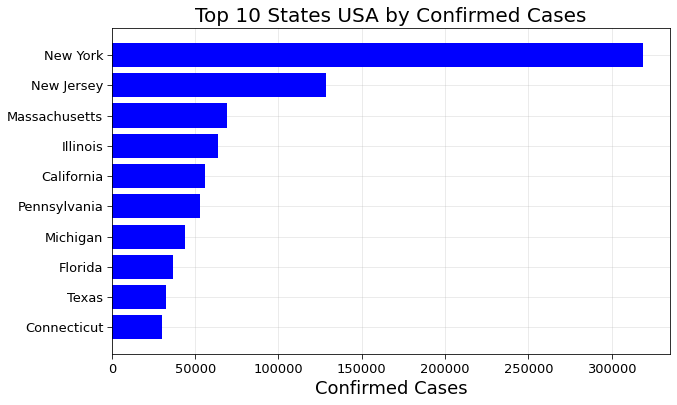

In [0]:
f = plt.figure(figsize=(10,6))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_viz.groupby(["State"]).sum().sort_values('Confirmed')["Confirmed"].index[-10:],df_viz.groupby(["State"]).sum().sort_values('Confirmed')["Confirmed"].values[-10:],color="Blue")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 States USA by Confirmed Cases",fontsize=20)
plt.grid(alpha=0.3)
plt.savefig('Top 10 States USA by Confirmed Cases.png')

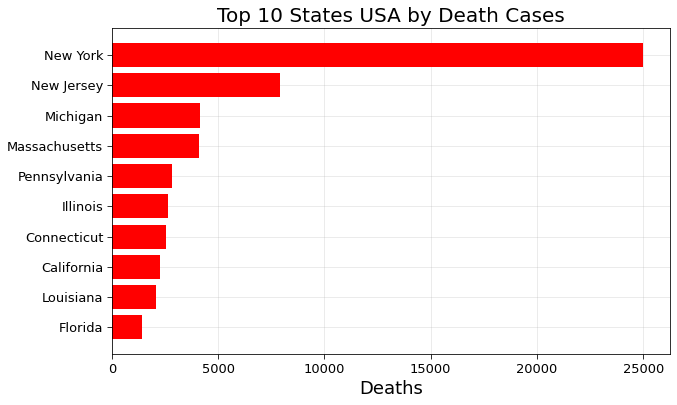

In [0]:
f = plt.figure(figsize=(10,6))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_viz.groupby(["State"]).sum().sort_values('Deaths')["Deaths"].index[-10:],df_viz.groupby(["State"]).sum().sort_values('Deaths')["Deaths"].values[-10:],color="Red")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths",fontsize=18)
plt.title("Top 10 States USA by Death Cases",fontsize=20)
plt.grid(alpha=0.3)
plt.savefig('Top 10 States USA by Death Cases.png')

In [0]:
import json, requests
import folium
state_geo = requests.get('https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json').json()
county_geo = requests.get('https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us_counties_20m_topo.json').json()

In [0]:
data_temp = df_viz.groupby(["State"]).sum().reset_index().drop(["Lat","Long_"],axis=1)
data_temp["Confirmed_log"] = np.log10(data_temp["Confirmed"]+1)
bins = list(data_temp['Confirmed_log'].quantile([0, 0.25, 0.5, 0.75,0.95 ,1]))
m = folium.Map(location=[37, -102], zoom_start=5,max_zoom=5,min_zoom=4)
 
# Add the color for the chloropleth:
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    title='Confirmed Cases HeatMap',
    data = data_temp,
    columns=['State', 'Confirmed_log'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.8,
    line_opacity=0.8,
    bins = bins,
    reset=True,
    legend_name='Confirmed cases log (10^x)'
).add_to(m)
folium.LayerControl().add_to(m)

m

## Models

In [0]:
data_usa = pd.DataFrame()
for i in range(1,30):
  date = datetime.strptime(df_confirmed.columns[-i],'%m/%d/%y').strftime("%m-%d-%Y")
  data_usa = data_usa.append(pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"+date+".csv"), ignore_index = True) 


In [0]:
data_usa = data_usa.loc[data_usa["Country_Region"]== "US"]
data_usa = data_usa.rename(columns={"Admin2":"County"}) 

In [0]:
data_usa = data_usa[['County', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key']]

In [0]:
data_usa['days'] = abs((pd.to_datetime(data_usa['Last_Update']) - (pd.to_datetime('today'))).dt.days)

In [0]:
# data_usa = data_usa[['Confirmed', 'Deaths', 'Recovered', 'days']]
data_usa['Combined_Key'] = data_usa['Province_State']+data_usa['Country_Region']
data_usa = data_usa[['Confirmed', 'Deaths', 'Recovered', 'days', 'Combined_Key']]

In [0]:
lb = LabelEncoder()
data_usa['Combined_Key'] = lb.fit_transform(data_usa['Combined_Key'])

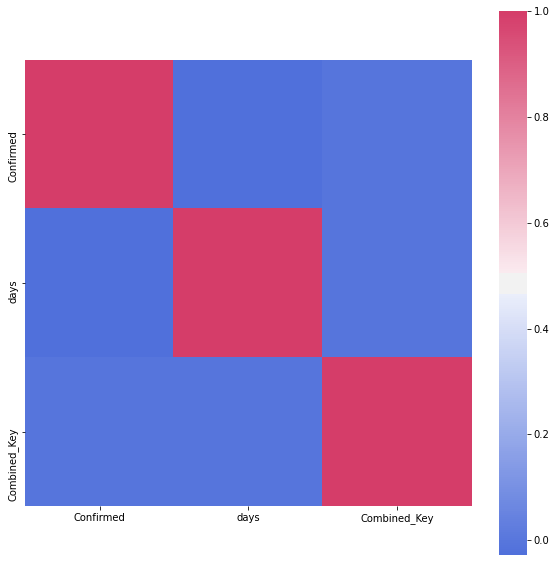

In [0]:
plt.figure(figsize = (10,10))
corr = data_usa[['Confirmed', 'days', 'Combined_Key']].corr()
sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) , cmap=sns.diverging_palette(-100,0,as_cmap=True) , square = True)

In [0]:
X = data_usa[['days', 'Combined_Key']].values
y = data_usa[['Confirmed']].values

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

###Linear Regression Model

In [0]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)

[24.68441687]
[[-0.79561955  0.01463936]]


In [0]:
y_pred = regressor.predict(X_test)

In [0]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df

In [0]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 18.663989199465917
Mean Squared Error: 14111.609473945458
Root Mean Squared Error: 118.79229551593596


### XGBRegressor Model

In [0]:
from xgboost import XGBRegressor
regressor = XGBRegressor(n_estimators = 2500 , random_state = 0 , max_depth = 27)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

[21:56:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
0,36,1.271498
1,6,15.392945
2,0,0.206763
3,0,2.822680
4,4,3.000015
...,...,...
15938,2,0.674980
15939,1,2.173927
15940,0,0.965467
15941,3,5.584634


In [0]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 16.187623435215123
Mean Squared Error: 14924.141674071056
Root Mean Squared Error: 122.16440428402643


###SVM

In [0]:
from sklearn import svm
regressor = svm.SVR()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
0,36,0.246279
1,6,1.251232
2,0,0.103324
3,0,0.196852
4,4,0.424611
...,...,...
15938,2,0.100239
15939,1,0.253732
15940,0,0.896056
15941,3,0.988845


In [0]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 9.587958913093328
Mean Squared Error: 14186.028535062322
Root Mean Squared Error: 119.10511548654122
